<a href="https://colab.research.google.com/github/jjooki/TIL/blob/main/bike.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric


import itertools
import numpy as np
import pandas as pd
import os
import holidays

train = pd.read_csv('/content/drive/MyDrive/dacon/data/bike/train.csv')
submission = pd.read_csv('/content/drive/MyDrive/dacon/data/bike/sample_submission.csv')
save_path = '/content/drive/MyDrive/dacon/'

train['일시'] = pd.to_datetime(train['일시'], format='%Y%m%d')

def predict(train, column):
    model = Prophet()
    df = pd.DataFrame()
    df['ds'] = train['일시']
    df['y'] = train[column]
    model.fit(df)
    future = model.make_future_dataframe(periods=334, freq='D')
    forecast = model.predict(future)
    return forecast.loc[1461:, 'yhat'].values

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

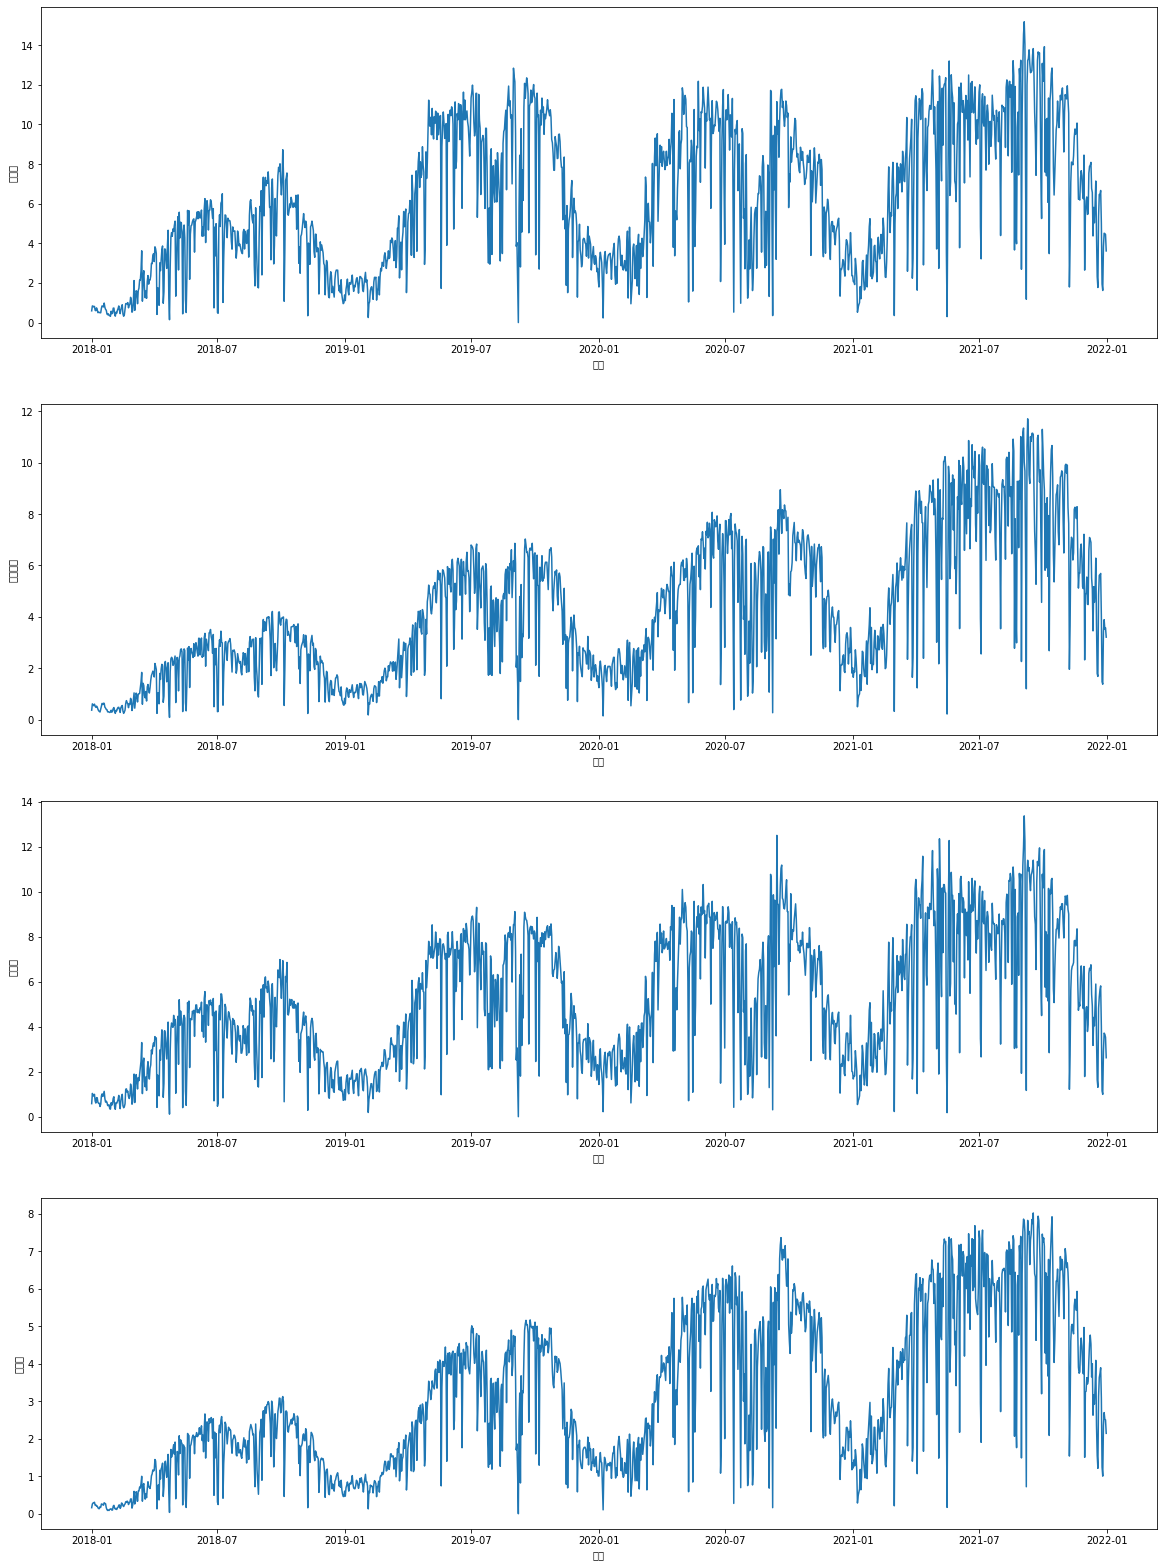

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

_, ax = plt.subplots(4, 1, figsize=(20, 28))
cols = ['광진구', '동대문구', '성동구', '중랑구']
for i in range(4):
    sns.lineplot(train['일시'], train[cols[i]], ci=None, ax=ax[i])
plt.show()

In [ ]:
model = Prophet()
df = pd.DataFrame()
df['ds'] = train['일시']
df['y'] = train['동대문구']
model.fit(df)

df_cv = cross_validation(model, horizon = '365 days')
df_cv

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp86_dkxch/sow9_56m.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp86_dkxch/rr_lhyxq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=74190', 'data', 'file=/tmp/tmp86_dkxch/sow9_56m.json', 'init=/tmp/tmp86_dkxch/rr_lhyxq.json', 'output', 'file=/tmp/tmp86_dkxch/prophet_model3aj2wk_e/prophet_model-20221115201204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:12:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:12:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs between 2020-12-31 00:00:00 and 2020-12-31 00:00:00


  0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp86_dkxch/zs4svlp4.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp86_dkxch/z91i634x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=96662', 'data', 'file=/tmp/tmp86_dkxch/zs4svlp4.json', 'init=/tmp/tmp86_dkxch/z91i634x.json', 'output', 'file=/tmp/tmp86_dkxch/prophet_modelfexoe1tc/prophet_model-20221115201204.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:12:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:12:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-01-01,3.267902,1.851945,4.530542,1.650,2020-12-31
1,2021-01-02,2.956458,1.531307,4.244118,1.906,2020-12-31
2,2021-01-03,2.647117,1.319829,3.903786,1.854,2020-12-31
3,2021-01-04,3.268249,2.059280,4.603005,2.716,2020-12-31
4,2021-01-05,3.534857,2.202193,4.878281,2.372,2020-12-31
...,...,...,...,...,...,...
360,2021-12-27,4.011642,2.656576,5.429957,3.416,2020-12-31
361,2021-12-28,4.244113,2.831606,5.642018,3.890,2020-12-31
362,2021-12-29,4.057092,2.591271,5.455905,3.524,2020-12-31
363,2021-12-30,4.123294,2.812448,5.475053,3.574,2020-12-31


In [ ]:
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,2.169825,1.473033,1.270338,0.900799,0.581168,0.496966,0.527778
1,37 days,2.097221,1.448178,1.227120,0.874093,0.520688,0.479226,0.555556
2,38 days,2.067040,1.437720,1.201559,0.860117,0.478369,0.468526,0.555556
3,39 days,2.059232,1.435003,1.195913,0.853980,0.478369,0.463944,0.555556
4,40 days,2.052473,1.432646,1.187471,0.850338,0.478369,0.460754,0.555556
...,...,...,...,...,...,...,...,...
325,361 days,1.887331,1.373802,1.105740,0.320595,0.164383,0.260079,0.555556
326,362 days,1.887715,1.373941,1.106297,0.321496,0.164383,0.260820,0.555556
327,363 days,1.894806,1.376520,1.116382,0.324870,0.164383,0.263886,0.555556
328,364 days,1.851602,1.360736,1.093787,0.323435,0.154045,0.261493,0.583333


/usr/local/lib/python3.7/dist-packages/prophet/plot.py:544: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.7/dist-packages/prophet/plot.py:545: FutureWarning: casting timedelta64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').astype(np.int64) / float(dt_conversions[i])


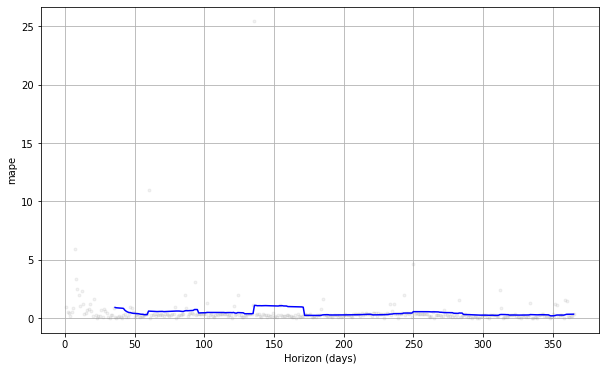

In [ ]:
fig = plot_cross_validation_metric(df_cv, metric='mape')

In [ ]:
"""
Hyper-parameter Tuning with Prophet
Tutorial
"""

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    model = Prophet(**params)
    df = pd.DataFrame()
    df['ds'] = train['일시']
    df['y'] = train['광진구']
    model.fit(df)  # Fit model with given params
    df_cv = cross_validation(model, horizon='365 days', parallel="processes")
    df_p = performance_metrics(df_cv)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp86_dkxch/zoigzshi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp86_dkxch/bjch7w2s.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5849', 'data', 'file=/tmp/tmp86_dkxch/zoigzshi.json', 'init=/tmp/tmp86_dkxch/bjch7w2s.json', 'output', 'file=/tmp/tmp86_dkxch/prophet_modeldj8o_7mc/prophet_model-20221115201540.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:15:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:15:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
20:15:40 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error durin

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01         additive   
1                     0.001                     0.01   multiplicative   
2                     0.001                     0.10         additive   
3                     0.001                     0.10   multiplicative   
4                     0.001                     1.00         additive   
5                     0.001                     1.00   multiplicative   
6                     0.001                    10.00         additive   
7                     0.001                    10.00   multiplicative   
8                     0.010                     0.01         additive   
9                     0.010                     0.01   multiplicative   
10                    0.010                     0.10         additive   
11                    0.010                     0.10   multiplicative   
12                    0.010                     1.0

In [ ]:
tuning_results = tuning_results.sort_values(by=['rmse'])
final_param = tuning_results.iloc[0, :-1].to_dict()
m = Prophet(**final_param).fit(df)
future = m.make_future_dataframe(periods=334, freq='D')
forecast = m.predict(future)
forecast.loc[1461:, 'yhat'].values

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp86_dkxch/cjqi9v44.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp86_dkxch/7czgrvy_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=31009', 'data', 'file=/tmp/tmp86_dkxch/cjqi9v44.json', 'init=/tmp/tmp86_dkxch/7czgrvy_.json', 'output', 'file=/tmp/tmp86_dkxch/prophet_model92ziyo0s/prophet_model-20221115202909.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:29:10 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:29:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


array([ 3.24080716,  2.77656283,  3.09833145,  3.14880218,  3.47330001,
        3.46281849,  3.68258341,  3.31541236,  2.9017176 ,  3.26855176,
        3.35399995,  3.70548727,  3.71171699,  3.940579  ,  3.57222232,
        3.15003165,  3.50533683,  3.57305697,  3.90399153,  3.8856317 ,
        4.08938822,  3.6933588 ,  3.24426804,  3.5778384 ,  3.62569176,
        3.94163709,  3.91137481,  4.10907003,  3.7098459 ,  3.2627221 ,
        3.60668537,  3.66888796,  4.00497176,  3.99770447,  4.22293455,
        3.85184377,  3.43491274,  3.81371431,  3.91042634,  4.2822031 ,
        4.30874739,  4.56764497,  4.22636698,  3.83724766,  4.24497993,
        4.36741722,  4.76396317,  4.81204799,  5.09180899,  4.76780939,
        4.39499532,  4.82186275,  4.96252069,  5.37907525,  5.4469916 ,
        5.7491071 ,  5.44705926,  5.09822096,  5.55454412,  5.72589558,
        6.17645317,  6.27897551,  6.61817501,  6.35188555,  6.03900909,
        6.53407063,  6.74186169,  7.22788195,  7.36154872,  7.72

In [ ]:
forecast.loc[1461:, ['ds', 'yhat']]

,ds,yhat
1461,2022-01-01,3.240807
1462,2022-01-02,2.776563
1463,2022-01-03,3.098331
1464,2022-01-04,3.148802
1465,2022-01-05,3.473300
...,...,...
1790,2022-11-26,7.569874
1791,2022-11-27,6.960788
1792,2022-11-28,7.284986
1793,2022-11-29,7.284166


In [ ]:
cols

['광진구', '동대문구', '성동구', '중랑구']

In [39]:
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

import itertools
import numpy as np
import pandas as pd
import os
import holidays

train = pd.read_csv('/content/drive/MyDrive/dacon/data/bike/train.csv')
submission = pd.read_csv('/content/drive/MyDrive/dacon/data/bike/sample_submission.csv')
save_path = '/content/drive/MyDrive/dacon/'

train['일시'] = pd.to_datetime(train['일시'], format='%Y%m%d')

In [ ]:
def predict(train, column):
    """
    Basic prediction model
    """
    df = pd.DataFrame()
    df['ds'] = train['일시']
    df['y'] = train[column]
    model = Prophet().fit(df)
    future = model.make_future_dataframe(periods=334, freq='D')
    forecast = model.predict(future)
    return forecast.loc[1461:, 'yhat'].values

In [40]:
def predict2(train, region):
    """
    Upgraded prediction model with hyper-parameter tuning
    """
    # Make time series dataframe for each region
    df = pd.DataFrame()
    df['ds'] = train['일시']
    df['y'] = train[region]

    # Set the candidates of hyper-parameters
    param_grid = {  
        'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
        'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
        'seasonality_mode': ['additive', 'multiplicative']
    }

    # Generate all combinations of parameters
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
    maes = []  # Store the RMSEs for each params here

    # Use cross validation to evaluate all parameters
    for params in all_params:
        model = Prophet(**params)
        model.fit(df)  # Fit model with given params
        df_cv = cross_validation(model, horizon='365 days', parallel="processes")
        df_p = performance_metrics(df_cv)
        maes.append(df_p['mae'].values[0])

    # Find the best parameters
    tuning_results = pd.DataFrame(all_params)
    tuning_results['mae'] = maes
    tuning_results = tuning_results.sort_values(by=['mae']) # Sorted by rmes values
    final_param = tuning_results.iloc[0, :-1].to_dict() # Pick the optimized(having minimum rmse value) hyper-parameter combination
    print(f'---------- Hyper-parameter of {region} ----------')
    print(final_param)

    # Train the final model with optimized params
    m = Prophet(**final_param).fit(df)
    future = m.make_future_dataframe(periods=334, freq='D')
    forecast = m.predict(future)
    # Make the predict column for submission
    return forecast.loc[1461:, 'yhat'].values

In [41]:
for region in cols:
    submission[region] = predict2(train, region)

if 'submission_bike.csv' in os.listdir(save_path):
    count = 0
    for name in os.listdir(save_path):
        if 'submission_bike' in name:
            count += 1
    filename = f"submission_bike{count + 1}.csv"
else:
    filename = 'submission_bike.csv'

submission.to_csv(save_path + filename, index=False)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp86_dkxch/oy855ffs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp86_dkxch/71l9sigg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95096', 'data', 'file=/tmp/tmp86_dkxch/oy855ffs.json', 'init=/tmp/tmp86_dkxch/71l9sigg.json', 'output', 'file=/tmp/tmp86_dkxch/prophet_model_2pyygh_/prophet_model-20221115205841.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
20:58:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
20:58:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
20:58:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
ERROR:cmdstanpy:Chain [1] error: error duri

---------- Hyper-parameter of 광진구 ----------
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


21:01:08 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp86_dkxch/gmkmj7cj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp86_dkxch/ygki9qp2.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=21118', 'data', 'file=/tmp/tmp86_dkxch/gmkmj7cj.json', 'init=/tmp/tmp86_dkxch/ygki9qp2.json', 'output', 'file=/tmp/tmp86_dkxch/prophet_modelf32bxn6_/prophet_model-20221115210109.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:01:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:01:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Making 1 forecasts with cutoffs b

---------- Hyper-parameter of 동대문구 ----------
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


21:03:03 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp86_dkxch/quepn95p.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp86_dkxch/43hx870q.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68752', 'data', 'file=/tmp/tmp86_dkxch/quepn95p.json', 'init=/tmp/tmp86_dkxch/43hx870q.json', 'output', 'file=/tmp/tmp86_dkxch/prophet_modelurl532c6/prophet_model-20221115210304.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:03:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:03:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
21:03:04 - cmdstanpy - ERROR - Chain [1] error

---------- Hyper-parameter of 성동구 ----------
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}


21:05:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp86_dkxch/8wbc5sw9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp86_dkxch/z1tmmif9.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.7/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40329', 'data', 'file=/tmp/tmp86_dkxch/8wbc5sw9.json', 'init=/tmp/tmp86_dkxch/z1tmmif9.json', 'output', 'file=/tmp/tmp86_dkxch/prophet_model6gkjgnap/prophet_model-20221115210522.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:05:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:05:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
21:05:22 - cmdstanpy - ERROR - Chain [1] error

---------- Hyper-parameter of 중랑구 ----------
{'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}


21:07:46 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
